**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Z-критерий для двух долей 

In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
import scipy
import statsmodels
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.16.2
0.24.2
1.2.1
0.9.0


## Загрузка данных

In [8]:
data = pd.read_csv('banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']

In [9]:
data.head()

,banner_a,banner_b
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [10]:
data.describe()

,banner_a,banner_b
count,1000.000000,1000.000000
mean,0.037000,0.053000
std,0.188856,0.224146
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


## Интервальные оценки долей

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [11]:
conf_interval_banner_a = proportion_confint(sum(data.banner_a), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_banner_b = proportion_confint(sum(data.banner_b), 
                                            data.shape[0],
                                            method = 'wilson')

In [12]:
print('95%% confidence interval for a click probability, banner a: [%f, %f]' % conf_interval_banner_a)
print('95%% confidence interval for a click probability, banner b [%f, %f]' % conf_interval_banner_b)

95% confidence interval for a click probability, banner a: [0.026961, 0.050582]
95% confidence interval for a click probability, banner b [0.040747, 0.068675]


## Z-критерий для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [13]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [14]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [15]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [16]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(data.banner_a, data.banner_b))

95% confidence interval for a difference between proportions: [-0.034157, 0.002157]


In [17]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.banner_a, data.banner_b)))

p-value: 0.084379


In [18]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.banner_a, data.banner_b), 'less'))

p-value: 0.042189


## Z-критерий для разности долей (связанные выборки)

  $X_1$ \ $X_2$ | 1| 0 | $\sum$
  ------------- | -------------|
  1  | e | f | e + f
  0  | g | h | g + h
  $\sum$ | e + g| f + h | n  
  
$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

$$Z-статистика: Z({X_1, X_2}) = \frac{f - g}{\sqrt{f + g - \frac{(f-g)^2}{n}}}$$

In [19]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [20]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [21]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" \
      % proportions_diff_confint_rel(data.banner_a, data.banner_b))

95% confidence interval for a difference between proportions: [-0.026689, -0.005311]


In [22]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(data.banner_a, data.banner_b)))

p-value: 0.003349


In [23]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(data.banner_a, data.banner_b), 'less'))

p-value: 0.001675


**В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате.**

**Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён.**

**Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки**

In [24]:
n=50
p1=10/34
p2=4/16

In [25]:
p2-p1

-0.04411764705882354

In [31]:
contr=np.append(np.ones(4),np.zeros(12))

In [32]:
test=np.append(np.ones(10),np.zeros(24))

In [34]:
test_a = proportion_confint(sum(test), 
                                            len(test),
                                            method = 'wilson')
contr_a= proportion_confint(sum(contr), 
                                             len(contr),
                                            method = 'wilson')

In [36]:
test_a, contr_a

((0.16834630670422424, 0.4616890979471444),
 (0.10182067491213043, 0.4949831653550878))

In [38]:
proportions_diff_confint_ind(test, contr)

(-0.2175577216559601, 0.3057930157736072)

заразительная ли зевтота.
а это значит, что нулевая: незаразительна / 
альтернатива: заразительна
то есть в экспериментальной группе будет не меньше доля зевающий (>=) - 'greater'

In [57]:
proportions_diff_z_test(proportions_diff_z_stat_ind(test, contr), alternative = 'greater')

0.37293045872523534

**p-value 0.37 говорит о вероятности при справедливости гипотизы Ho (зевота не заразительна) получить значение статитистики (Z) большей или равной в эксперименте (по модулю - хвосты кривой отклонения)  - по сути это распределение отклонений. если мальеньк p-value( большое Z)  - то это говорит,  что маловероятно, что наблюдаемая пространственная модель отражает теоретическую случайную структурную закономерность, представленную нулевой гипотезой! - т.е. мала вероятность при верности H0 получить H1**

**в данном примере p-value велико , а значит высока  вероятность ошибочно отвергнуть гипотезу о равенстве средних двух выборок, когда в действительности эта гипотеза имеет место. Иными словами, он равен вероятности ошибки принять гипотезу о том что зевота заразительна - больше зеваюших, когда в действительности нет!**

**Имеются данные измерений двухсот швейцарских тысячефранковых банкнот, бывших в обращении в первой половине XX века. Сто из банкнот были настоящими, и сто — поддельными. На рисунке ниже показаны измеренные признаки:**

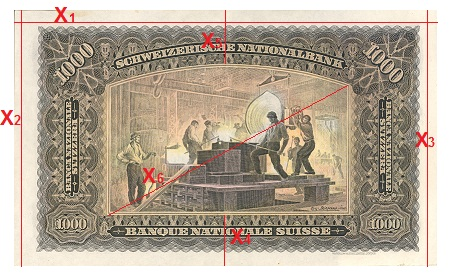

In [46]:
from IPython.display import Image
Image("back_horizontal.jpg")

Отделите 50 случайных наблюдений в тестовую выборку с помощью функции sklearn.cross_validation.train_test_split (зафиксируйте random state = 1). На оставшихся 150 настройте два классификатора поддельности банкнот:

In [253]:
data= pd.read_csv('banknotes.txt', sep = '\t')


In [254]:
data.head()

,X1,X2,X3,X4,X5,X6,real
0,214.8,131.0,131.1,9.0,9.7,141.0,1
1,214.6,129.7,129.7,8.1,9.5,141.7,1
2,214.8,129.7,129.7,8.7,9.6,142.2,1
3,214.8,129.7,129.6,7.5,10.4,142.0,1
4,215.0,129.6,129.7,10.4,7.7,141.8,1


In [255]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [256]:
x_data=data.drop('real',axis=1)
y_data=data['real']

In [257]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.25,random_state = 1)

логистическая регрессия по признакам X_1,X_2,X_3X 

логистическая регрессия по признакам X_4,X_5,X_6X 

Каждым из классификаторов сделайте предсказания меток классов на тестовой выборке. Одинаковы ли доли ошибочных предсказаний двух классификаторов? Проверьте гипотезу, вычислите достигаемый уровень значимости. Введите номер первой значащей цифры (например, если вы получили 5.5\times10^{-8}5.5×10 
−8
 , нужно ввести 8).

In [258]:
x_train.iloc[:,0:3].head()

,X1,X2,X3
98,215.1,130.0,129.8
123,215.1,130.7,130.4
119,214.4,130.2,129.9
53,215.4,130.2,130.2
33,215.6,130.4,130.1


In [259]:
x_train.iloc[:,3:6].head()

,X4,X5,X6
98,9.1,10.2,141.5
123,10.5,11.2,139.7
119,10.1,12.0,139.2
53,7.6,10.9,141.6
33,8.4,10.3,141.0


In [260]:
lr = LogisticRegression()
lr.fit(x_train.iloc[:,0:3], y_train)

C:\Users\unikum\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [261]:
lr1 = LogisticRegression()
lr1.fit(x_train.iloc[:,3:6], y_train)

C:\Users\unikum\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [262]:
сlf1=lr.predict(x_test.iloc[:,0:3])

In [263]:
clf2=lr1.predict(x_test.iloc[:,3:6])

In [264]:
from sklearn import metrics

In [265]:
metrics.accuracy_score(сlf1,y_test)

0.8

In [266]:
metrics.accuracy_score(clf2,y_test)

0.98

In [267]:
from sklearn.metrics import accuracy_score

создадим руками векторы ошибок. если не верно то 1. иначе 0

In [268]:
class1=np.array([1 if сlf1[i]==y_test.array[i] else 0 for i in range(len(y_test))])

In [269]:
class1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1])

In [270]:
class2=np.array([1 if clf2[i]==y_test.values[i] else 0 for i in range(len(y_test))])

In [271]:
class2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [272]:
bla=lr1.predict(x_test.iloc[:,3:6])

H0 - доля ошибок одинакова. H1  -  не одинакова

In [273]:
proportions_diff_z_test(proportions_diff_z_stat_rel(class1,class2))

0.0032969384555543435

In [274]:
proportions_diff_z_test(proportions_diff_z_stat_rel(сlf1!=y_test,clf2!=y_test))

0.0032969384555543435

**Доли ошибок не одинаковы!**

**В предыдущей задаче посчитайте 95% доверительный интервал для разности долей ошибок двух классификаторов. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после десятичной точки.**

In [275]:
proportions_diff_confint_rel(class1, class2)

(-0.3000547937203857, -0.059945206279614305)

**Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет 525 баллов, стандартное отклонение — 100 баллов.**

**Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — 541.4. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает. Отвергается ли на уровне значимости 0.05 нулевая гипотеза? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки.**

H0 - не эффективна. H1 - работает . причем среднее больше среднего по нулевой гипотезе (1- F(Z))

In [276]:
X=525
sigma=100
X1=541.4
n=20000
n1=100


In [280]:
def p_value (mean,mean1,sigma,n):
    Z=(mean-mean1)/(sigma/np.sqrt(n))
    return (1 - scipy.stats.norm.cdf(Z))

In [286]:
p_value(541.4,525,100,100)

0.05050258347410397

**Оцените теперь эффективность подготовительных курсов, средний балл 100 выпускников которых равен 541.5. Отвергается ли на уровне значимости 0.05 та же самая нулевая гипотеза против той же самой альтернативы? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки.**

In [287]:
p_value(541.5,525,100,100)

0.0494714680336481

In [231]:
lr1.predict(x_test.iloc[:,3:6])==clf2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [230]:
clf2[1]

1